In [74]:
from qiskit_ibm_runtime import QiskitRuntimeService

token = '4c635c9b66b0ab2f37ce29d7bc33edc66f815847092ba236aa79748304b2cd4bbba6c35d8a4a6adc9b579b1990cfa8066f5220cbdc29044dc9bd59f1c1e1ea1b'
instance = 'ibm-q/open/main'

service = QiskitRuntimeService(
        channel='ibm_quantum',
        instance=instance,
        token=token
)

# Save your IBM Quantum API key in
# ~/.qiskit/qiskit-ibm.json
service.save_account(channel="ibm_quantum", 
                                  token=token,
                                  overwrite=True)

## Define the Quantum Circuit (qc)

In [75]:
from qiskit import QuantumCircuit, ClassicalRegister

def create_quantum_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    # Apply Hadamard gate to each qubit
    for i in range(num_qubits):
        qc.h(i)
    # Apply CNOT gate between each pair of qubits
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
    # Add classical registers and measurements
    cr = ClassicalRegister(num_qubits)
    qc.add_register(cr)
    qc.measure(range(num_qubits), range(num_qubits))
    return qc

# Specify the number of qubits
num_qubits = 6  # Change this value as needed
qc = create_quantum_circuit(num_qubits)

print(qc)

      ┌───┐          ┌─┐                              
 q_0: ┤ H ├──■───────┤M├──────────────────────────────
      ├───┤┌─┴─┐     └╥┘     ┌─┐                      
 q_1: ┤ H ├┤ X ├──■───╫──────┤M├──────────────────────
      ├───┤└───┘┌─┴─┐ ║      └╥┘     ┌─┐              
 q_2: ┤ H ├─────┤ X ├─╫───■───╫──────┤M├──────────────
      ├───┤     └───┘ ║ ┌─┴─┐ ║      └╥┘     ┌─┐      
 q_3: ┤ H ├───────────╫─┤ X ├─╫───■───╫──────┤M├──────
      ├───┤           ║ └───┘ ║ ┌─┴─┐ ║      └╥┘┌─┐   
 q_4: ┤ H ├───────────╫───────╫─┤ X ├─╫───■───╫─┤M├───
      ├───┤           ║       ║ └───┘ ║ ┌─┴─┐ ║ └╥┘┌─┐
 q_5: ┤ H ├───────────╫───────╫───────╫─┤ X ├─╫──╫─┤M├
      └───┘           ║       ║       ║ └───┘ ║  ║ └╥┘
c3: 6/════════════════╩═══════╩═══════╩═══════╩══╩══╩═
                      0       1       2       3  4  5 


### Print out the IBM Quantum details: instances and backends 
- to be used for Testing quality of backends at different qubit sizes

In [115]:
print(service.instances())
print(service.backends())

print(f"backend_names = {[backend.name for backend in service.backends()]}")

['ibm-q/open/main']
[<IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_brisbane')>]
backend_names = ['ibm_sherbrooke', 'ibm_kyiv', 'ibm_brisbane']


## Run the Sampler program across the QuantumCircuit(qc) and Backends defined above
- uses the service() account logged into at the top with the given token
- token should be saved in ~/.qiskit/

In [164]:
from qiskit_ibm_runtime import Sampler # old Sampler
#from qiskit.primitives import StatevectorSampler   # new Sampler, with quasi_dists
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# List of backend names
backend_names = ['ibm_brisbane', 'ibm_sherbrooke', 'ibm_kyiv']  # Replace with your list of backends

def run_program(backend_name, qc):
    try:
        # Get the backend
        backend = service.backend(backend_name)
        # Set up pass_manager for backend
        pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

        # Run pass_manager through transpiler
        qc_transpiled = pass_manager.run(qc)

        # Run the Sampler job
        sampler = Sampler() # old Sampler
        #sampler = StatevectorSampler() # new Sampler
        job = sampler.run(pubs=[qc_transpiled])
        
        return job.job_id()
    except Exception as e:
        print(f"Error running program on backend {backend_name}: {e}")
        return None

# Run the jobs on the backends and capture job_id and backend_name
jobs_backend = []
for backend_name in backend_names:
    print(f"Submitting to: {backend_name}")
    job_id = run_program(backend_name, qc)
    if job_id:
        jobs_backend.append((job_id, backend_name))
        print(f"Job ID: {job_id}")
    else:
        print(f"Failed to submit job to {backend_name}")

print(f"jobs_backend = {jobs_backend}")

Submitting to: ibm_brisbane
Job ID: eaa28388-340e-4a8d-9ead-3d1394c999a6
Submitting to: ibm_sherbrooke
Job ID: 342f95ff-6219-4fed-8e33-15c02379d779
Submitting to: ibm_kyiv
Job ID: 735d7e16-11e6-491f-aebc-17087e4bb619
jobs_backend = [('eaa28388-340e-4a8d-9ead-3d1394c999a6', 'ibm_brisbane'), ('342f95ff-6219-4fed-8e33-15c02379d779', 'ibm_sherbrooke'), ('735d7e16-11e6-491f-aebc-17087e4bb619', 'ibm_kyiv')]


### When programs are finished, call the job_ids and compare results

In [170]:
# pub_result = job_result[<idx>].data.<classical register>.get_counts()
#
# where <idx> is the index of the pub and <classical register> is the name of the classical register. 
# You can use circuit.cregs to find the name of the classical registers.

job_id = 'cxxe56w4a290008xzse0' # old sampler style
#job_id = ''# new sampler style
result = service.job(job_id).result()[0] 
print(result)
print(f"{result.data.c3.get_counts()}")  # corrected access to data attribute
#print(f"{result.quasi_dists}") # new sampler style

SamplerPubResult(data=DataBin(c3=BitArray(<shape=(), num_shots=4096, num_bits=6>)), metadata={'circuit_metadata': {}})
{'111010': 66, '101111': 88, '101000': 79, '000100': 62, '000010': 76, '100000': 75, '101100': 82, '101110': 78, '111111': 68, '010111': 48, '011111': 49, '111001': 64, '011101': 42, '001110': 68, '110111': 51, '000101': 83, '101010': 74, '001000': 78, '100011': 76, '100001': 83, '110011': 48, '000110': 91, '010110': 33, '010101': 48, '100111': 89, '111110': 67, '001011': 83, '000001': 64, '001111': 77, '000111': 85, '000000': 77, '110101': 42, '110100': 47, '111100': 58, '110010': 74, '011000': 37, '011011': 54, '010010': 41, '111011': 76, '111000': 38, '011001': 51, '100101': 76, '010100': 45, '111101': 63, '001100': 70, '100100': 58, '101001': 74, '100110': 83, '101101': 76, '110110': 51, '000011': 77, '010001': 36, '010011': 37, '001101': 77, '100010': 76, '001010': 82, '110001': 59, '011100': 35, '001001': 81, '010000': 47, '011010': 54, '110000': 57, '011110': 43

        ibm_sherbrooke  ibm_brisbane  ibm_kyiv
111010              66            73        65
101111              88            77        60
101000              79            42        60
000100              62            62        60
000010              76            51        47
...                ...           ...       ...
010000              47            60        59
011010              54            68        59
110000              57            47        62
011110              43            86        64
101011              69            67        63

[64 rows x 3 columns]


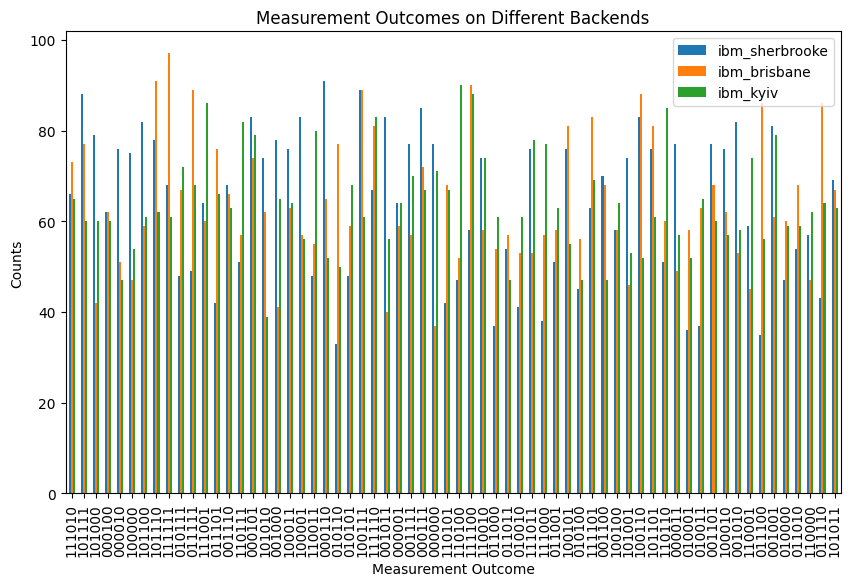

In [173]:
import pandas as pd
import matplotlib.pyplot as plt
from qiskit.quantum_info import state_fidelity, Statevector
import time

# Function to check job status and retrieve results
def get_job_result(job_id):
    try:
        job = service.job(job_id)
        while job.status() not in ['DONE', 'CANCELLED', 'ERROR']:
            print(f"Job {job_id} status: {job.status()}")
            time.sleep(10)  # Wait for 10 seconds before checking the status again
        if job.status() == 'DONE':
            result = job.result()
            counts = result[0].data.c3.get_counts()
            return counts
        else:
            print(f"Job {job_id} failed with status: {job.status()}")
            return None
    except Exception as e:
        print(f"Error retrieving result for job {job_id}: {e}")
        return None

# Retrieve the results
results = {}
for job_id, backend_name in jobs_backend:
    counts = get_job_result(job_id)
    if counts:
        results[backend_name] = counts

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Display the results as a table
print(df)

# Plot the results
df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Measurement Outcome')
plt.ylabel('Counts')
plt.title('Measurement Outcomes on Different Backends')
plt.show()

# Calculate and display fidelity between the results of different backends
ideal_backend = backend_names[0]
ideal_counts = results.get(ideal_backend)


In [178]:
from qiskit.quantum_info import state_fidelity, Statevector

# Calculate and display fidelity between the results of different backends
ideal_backend = backend_names[0]
ideal_counts = results.get(ideal_backend)

if ideal_counts:
    fidelities = {}
    for backend_name in backend_names[1:]:
        if backend_name in results:
            # Convert counts to state vectors
            ideal_statevector = Statevector.data.from_counts(ideal_counts)
            backend_statevector = Statevector.from_counts(results[backend_name])
            fidelity = state_fidelity(ideal_statevector, backend_statevector)
            fidelities[backend_name] = fidelity

    print(f"Fidelities compared to {ideal_backend}:")
    for backend_name, fidelity in fidelities.items():
        print(f"{backend_name}: {fidelity}")
else:
    print(f"No results available for the ideal backend: {ideal_backend}")

AttributeError: 'property' object has no attribute 'from_counts'

In [ ]:
#jobs_backend = [('cxwq5gp4a290008xy8g0', 'ibm_brisbane'), ('cxwq5hywk6yg008j15e0', 'ibm_sherbrooke'), ('cxwq5ke4a290008xy8gg', 'ibm_kyiv')]
# Submitting to: ibm_brisbane
# Job ID: cxxe54m082700084a6p0
# Submitting to: ibm_sherbrooke
# Job ID: cxxe56w4a290008xzse0
# Submitting to: ibm_kyiv
# Job ID: cxxe58n0v1500080mc20
jobs_backend = [('cxxe54m082700084a6p0', 'ibm_brisbane'), ('cxxe56w4a290008xzse0', 'ibm_sherbrooke'), ('cxxe58n0v1500080mc20', 'ibm_kyiv')]